# Imports

In [13]:
import cv2 
import json
import random
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential,load_model
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

# Import dataframe

In [57]:
df = pd.read_pickle('./output/dataCleanGrayDef.pkl')
df

,sex,array
0,men,"[[78, 79, 79, 79, 80, 80, 81, 81, 80, 78, 80, ..."
1,men,"[[18, 27, 32, 27, 39, 41, 41, 41, 48, 65, 65, ..."
2,men,"[[89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, ..."
3,men,"[[30, 31, 37, 37, 31, 26, 30, 21, 22, 23, 22, ..."
4,men,"[[255, 255, 254, 255, 255, 253, 247, 85, 25, 8..."
...,...,...
3325,women,"[[167, 169, 172, 189, 209, 225, 235, 240, 244,..."
3326,women,"[[62, 59, 62, 58, 61, 42, 44, 78, 106, 117, 12..."
3327,women,"[[35, 27, 31, 24, 30, 24, 24, 22, 22, 21, 22, ..."
3328,women,"[[96, 87, 99, 120, 126, 135, 153, 173, 178, 13..."


In [58]:
df['sex'] = df['sex'].apply(lambda x: np.where(x == 'men', 0, 1))

In [59]:
X = np.stack(df['array'])
y = np.stack(df['sex'])

In [60]:
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [61]:
n_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=n_classes, dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes=n_classes, dtype='float32')

In [62]:
train_X.shape

(2248, 60, 60)

# Sequential model

In [71]:
model = Sequential()
chanDim = -1

if K.image_data_format() == 'channels_first':
    train_X = train_X.reshape(train_X.shape[0], 1, 60, 60)
    test_X = test_X.reshape(test_X.shape[0], 1, 60, 60)
    input_shape = (1, 60, 60)
else:
    train_X = train_X.reshape(train_X.shape[0], 60, 60, 1)
    test_X = test_X.reshape(test_X.shape[0], 60, 60, 1)
    input_shape = (60, 60, 1)
    
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(60,60,1)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

# CNN params

EPOCHS = 20
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

#Training the model

model.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 60, 60, 32)        320       
_________________________________________________________________
activation_22 (Activation)   (None, 60, 60, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
activation_23 (Activation)   (None, 20, 20, 64)       

# Fitting model

In [72]:
history = model.fit(train_X, y_train,
        batch_size = BS,
        epochs = EPOCHS,
        verbose = 1,
        validation_data = (test_X, y_test))

Train on 2248 samples, validate on 562 samples
Epoch 1/20
2248/2248 [==============================] - 34s 15ms/step - loss: 1.0249 - accuracy: 0.6321 - val_loss: 1.0609 - val_accuracy: 0.5996
Epoch 2/20
2248/2248 [==============================] - 34s 15ms/step - loss: 0.7056 - accuracy: 0.6953 - val_loss: 0.5046 - val_accuracy: 0.7580
Epoch 3/20
2248/2248 [==============================] - 31s 14ms/step - loss: 0.5890 - accuracy: 0.7367 - val_loss: 0.5810 - val_accuracy: 0.7278
Epoch 4/20
2248/2248 [==============================] - 30s 13ms/step - loss: 0.5615 - accuracy: 0.7593 - val_loss: 0.5766 - val_accuracy: 0.7189
Epoch 5/20
2248/2248 [==============================] - 30s 13ms/step - loss: 0.5188 - accuracy: 0.7834 - val_loss: 0.4602 - val_accuracy: 0.7776
Epoch 6/20
2248/2248 [==============================] - 31s 14ms/step - loss: 0.4752 - accuracy: 0.7936 - val_loss: 0.4209 - val_accuracy: 0.7900
Epoch 7/20
2248/2248 [==============================] - 30s 13ms/step - loss:

### Model accuracy

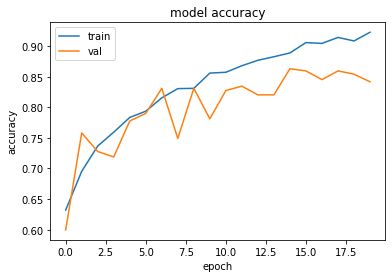

In [73]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model loss

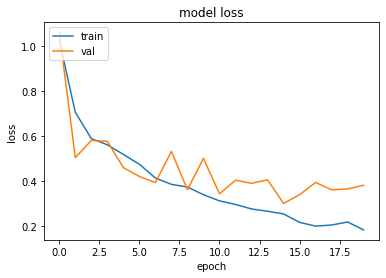

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing model

In [75]:
scores = model.evaluate(test_X, y_test, verbose = 0)

print('Accuracy: %.2f%%' % (scores[1] * 100))
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Accuracy: 84.16%
Test loss: 0.38147813240828465
Test accuracy: 0.8416370153427124


In [76]:
Y_pred = model.predict(test_X)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1)

In [77]:
print(Y_pred_classes)
print(Y_true)

[0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1
 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0
 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1
 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0
 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0
 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1
 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0
 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1
 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1
 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1
 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0
 1 1 0 1 0 0 0 1 1 1 0 0 

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

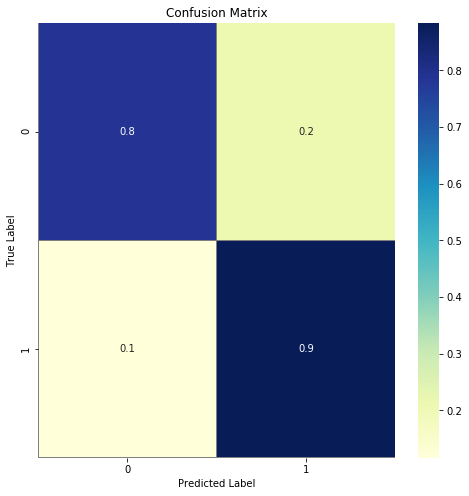

In [79]:
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Save model

In [80]:
mod = f'model_sequential{(scores[1] * 100)}'
model.save('./output' + mod + '.h5')

In [81]:
model_json = model.to_json()
with open('./output' + mod + '.json', "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights(mod)

# Loading model

In [96]:
with open('./output/model_sequential84.16370153427124.json','r') as f:
    model_json = json.load(f)
    
model = model_from_json(model_json)

model.load_weights('./output/model_sequential84.16370153427124.h5')

### Prediction with test

(60, 60, 1)
Probs 
man - 0.98296 
woman - 0.01704


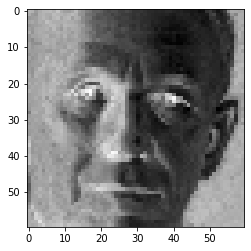

In [137]:
random_indices = [random.randint(0, len(test_X))][0]

img = test_X[random_indices]
print(img.shape)
pred = model.predict(np.expand_dims(img,axis=0))[0]
print('Probs \nman - {0:.5f} \nwoman - {1:.5f}'.format(pred[0],pred[1]))

plt.imshow(Image.fromarray(img.squeeze()*255), cmap='gray', interpolation='none')

### Prediction with outside

In [115]:
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

In [133]:
def cleanData(img):
    '''
    Reconoce el rostro de personas sobre imágenes:
    - Crea una sección que encuadra el rostro.
    - Transforma la imagen a escala de grises.
    - Reescala la imagen a 48x48.
    - Traduce la información del cuadrante a np.array.
    
    En el caso de no reconocer ningun rostro devuelve /no.
    '''
    try:
        image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        face_p = face_cascade.detectMultiScale(
            image,
            scaleFactor=1.1,
            minNeighbors=5
        )

        (x, y, w, h) = face_p[0]

        crop_image = image[y:y+h,x:x+w]

        img_data = cv2.resize(crop_image,(60,60))
        img_data = np.stack(img_data)
        
    except Exception as e:
        return e,'no'
    
    return img_data
        

In [134]:
cleanData('/Users/marilomolinacandela/Desktop/IMG_3547.JPG')


array([[172, 171, 170, ..., 190, 192, 188],
       [174, 172, 172, ..., 186, 193, 192],
       [174, 178, 174, ..., 187, 192, 190],
       ...,
       [ 84,  84,  88, ..., 198, 200, 200],
       [ 87,  91,  82, ..., 200, 199, 201],
       [ 86,  91,  81, ..., 200, 203, 200]], dtype=uint8)

#### Man predict

[0.9961278  0.00387223]
Probs 
man - 0.99613 
woman - 0.00387


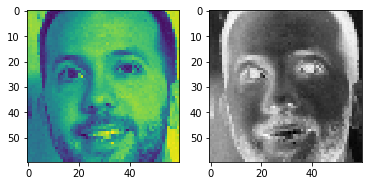

In [135]:
pruf = cleanData('/Users/marilomolinacandela/Desktop/IMG_3547.JPG')
input_pruf = cv2.imread('/Users/marilomolinacandela/Desktop/IMG_3547.JPG')

plt.subplot(121)
plt.imshow(pruf)
plt.subplot(122)
plt.imshow(Image.fromarray(pruf.squeeze()*255))

p = np.expand_dims(pruf,axis=0).reshape(np.expand_dims(pruf,axis=0).shape[0], 60, 60, 1)

pred = model.predict(p)[0]
print(pred)
print('Probs \nman - {0:.5f} \nwoman - {1:.5f}'.format(pred[0],pred[1]))

plt.imshow(Image.fromarray(pruf.squeeze()*255), cmap='gray', interpolation='none')

#### Woman predict

[0.0026939 0.9973061]
Probs 
man - 0.00269 
woman - 0.99731


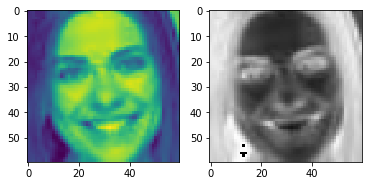

In [136]:
pruf = cleanData('/Users/marilomolinacandela/Desktop/pruf_w.jpeg')
input_pruf = cv2.imread('/Users/marilomolinacandela/pruf_w.jpeg')

plt.subplot(121)
plt.imshow(pruf)
plt.subplot(122)
plt.imshow(Image.fromarray(pruf.squeeze()*255))

p = np.expand_dims(pruf,axis=0).reshape(np.expand_dims(pruf,axis=0).shape[0], 60, 60, 1)

pred = model.predict(p)[0]
print(pred)
print('Probs \nman - {0:.5f} \nwoman - {1:.5f}'.format(pred[0],pred[1]))

plt.imshow(Image.fromarray(pruf.squeeze()*255), cmap='gray', interpolation='none')